In [91]:
import random
import numpy as np
np.random.seed(13)

import pandas as pd

from sklearn.datasets import load_digits
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt

def pprint(x, x_name):
    if len(x.shape) > 1:
        print(f"{x_name} =\n{x}")
    else:
        print(f"{x_name} = {x}")

# 1. Non-negative matrix factorization

## 1.1 Implementation

In [2]:
digits = load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [3]:
data = np.array(digits["data"])
images = np.array(digits["images"])
target = np.array(digits["target"])
target_names = digits["target_names"]

In [4]:
pprint(data, "data")
print("data.shape", data.shape)

data =
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
data.shape (1797, 64)


In [5]:
print("target.shape", target.shape)
print("target.unique =\n", np.stack(np.unique(target, return_counts=True), axis=1))

target.shape (1797,)
target.unique =
 [[  0 178]
 [  1 182]
 [  2 177]
 [  3 183]
 [  4 181]
 [  5 182]
 [  6 181]
 [  7 179]
 [  8 174]
 [  9 180]]


### Seems balanced

<div style="color: green; font-weight: bold">Essentially the same but we didn't recalculate X after each iteration.</div>

In [11]:
def update_H(X, Z_t, H_t):

    num = Z_t.T @ X
    denom = (Z_t.T @ Z_t @ H_t)
    denom = np.clip(denom, a_min=np.nextafter(0, 1), a_max=np.max(denom))

    H_t1 = np.multiply(H_t, (num / denom))

    return H_t1


def update_Z(X, Z_t, H_t1):

    num = X @ H_t1.T
    denom = (Z_t @ H_t1 @ H_t1.T)
    denom = np.clip(denom, a_min=np.nextafter(0,1), a_max=np.max(denom))

    Z_t1 = np.multiply(Z_t, (num / denom))

    return Z_t1


def non_negative(data, num_components, t_dim=False):
    """
    Perform non-negative matrix factorization (nmf) on `data`.
    X ≈ Z x H while X,X,H > 0

    :param numpy.ndarray data: Input matrix to apply the mf on.
    :param int num_components: Number of components or features the common dimension will have.
    :param bool t_dim: Should the output vectors have an additional dimention where the results are saved for each t?
    :return: Z and H --> Two matrices, nmf whose multiplication results approximately in the original data matrix.
    """
    X = data

    N, D = data.shape
    M = num_components

    if t_dim:
        Z_long = []
        H_long = []


    # Initialize Ht and Zt as H_0 and Z_0
    Z = np.abs(np.random.randn(N,M))
    H = np.abs(np.random.randn(M,D))

    for t in range(1000):

        Z = update_Z(X, Z, H)
        H = update_H(X, Z, H)

        if t_dim:
            Z_long.append(Z)
            H_long.append((H))



    if t_dim:
        return Z_long, H_long
    else:
        return Z, H


def loss(X, Z, H):
    """
    Frobenius norm
    """
    if len(X.shape) == 2:
        return np.sum((X - Z @ H)**2)

    elif len(X.shape) ==3:
        return np.sum((X - Z @ H)**2, )

In [12]:
Z, H = non_negative(data, num_components=10)

In [13]:
model = NMF(n_components=10, init="random", max_iter=1000, random_state=13)
Z_skl = model.fit_transform(data)
H_skl = model.components_


<div style="color: green; font-weight: bold">We should have plotted H in a reshaped format instead of the linear vectors of Z.</div>

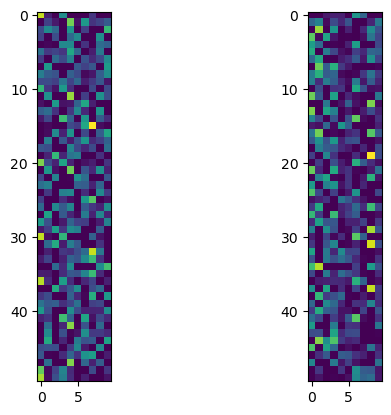

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(Z[:50], interpolation="nearest")
axes[1].imshow(Z_skl[:50], interpolation="nearest")

### They seem to be somewhat similar

In [16]:
Z_long, H_long = non_negative(data, num_components=10, t_dim=True)

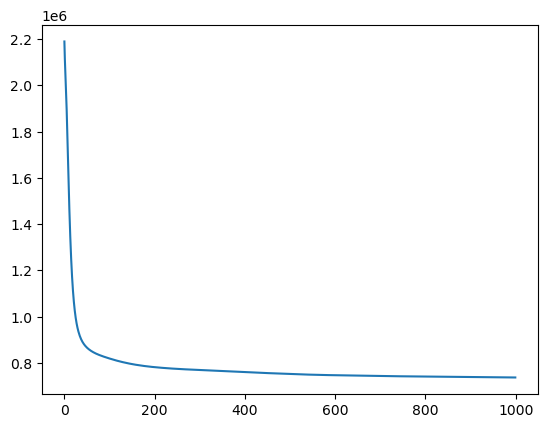

In [23]:
x = list(range(len(Z_long)))
y = []

for t in range(len(Z_long)):
    y.append(loss(data, Z_long[t], H_long[t]))

plt.plot(x, y)

### Loss is decreasing over t AKA confirmed to be non-increasing with t.


<div style="color: green; font-weight: bold">Seems correct but no official answer was provided.</div>

## 1.2 Recommender system


<div style="color: green; font-weight: bold">We should have plotted H in a reshaped format instead of the linear vectors of Z.</div>

In [95]:
# column headers for the dataset
ratings_cols = ['user id','movie id','rating','timestamp']
movies_cols = ['movie id','movie title','release date',
               'video release date','IMDb URL','unknown','Action',
               'Adventure','Animation','Childrens','Comedy','Crime',
               'Documentary','Drama','Fantasy','Film-Noir','Horror',
               'Musical','Mystery','Romance','Sci-Fi','Thriller',
               'War','Western']
users_cols = ['user id','age','gender','occupation',
              'zip code']

users = pd.read_csv('movielens-100k/ml-100k/u.user', sep='|',
                    names=users_cols, encoding='latin-1')
movies = pd.read_csv('movielens-100k/ml-100k/u.item', sep='|',
                     names=movies_cols,  encoding='latin-1')
ratings = pd.read_csv('movielens-100k/ml-100k/u.data', sep='\t',
                      names=ratings_cols, encoding='latin-1')

In [96]:
users

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [97]:
movies

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
ratings

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [99]:
# create a joint ratings dataframe for the matrix
fill_value = 0
rat_df = ratings.pivot(index='user id',
                       columns='movie id', values='rating').fillna(fill_value)
rat_df

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
rat_df_np = rat_df.to_numpy()
rat_df_np

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [101]:
N_movies = rat_df_np.shape[1]

In [78]:
x = np.arange(100, 400, step=100) # (100, N_movies, step=100) No time :(

y = []

for m in x:
    print(m)

    Z, H = non_negative(rat_df_np, m)

    sparsity = np.sum(Z == 0) / np.multiply(*Z.shape)
    y.append(sparsity)

100
200
300


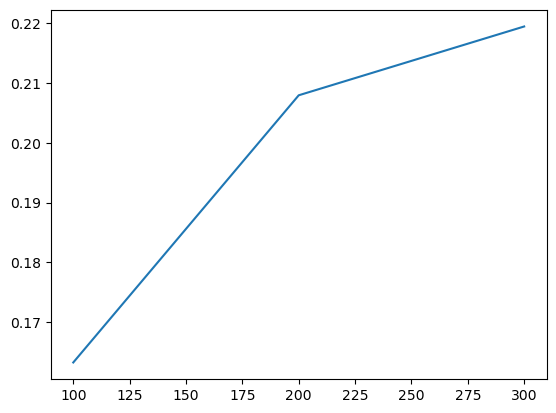

In [79]:
plt.plot(x,y)

### Apparently the more hidden features M, the higher the sparsity. Didn't have the computing power to try more Ms.


<div style="color: green; font-weight: bold">Forgot that user id starts with 1! We used a different approach in which we selected random movies above an arbitrary threshold of predicted ratings. Also we returned user recommended movies as numerical values instead of their entire information. We could have also compared latent features n=10 with genres to see if they decompose as such as is done in the solutions.</div>

In [145]:
class movie_recommender():

    def __init__(self, data, column_metadata, num_components):

        self.data = data
        self.col_metadata = column_metadata
        self.Z, self.H = non_negative(data.to_numpy(), num_components=num_components)
        self.X_hat = Z @ H

    def recommend(self, user_id, nr_recommendations=1):

        user_ratings = self.data.iloc[user_id]
        recommended_movies = user_ratings[user_ratings > 3]
        recommendation = random.sample(list(recommended_movies.index), k=nr_recommendations)
        recommendation = self.col_metadata.iloc[recommendation]['movie title']

        return recommendation

In [147]:
recommender = movie_recommender(data=rat_df, column_metadata=movies, num_components=100)
recommender.recommend(user_id=3, nr_recommendations=5)

50     Legends of the Fall (1994)
357                  Spawn (1997)
359             Wonderland (1997)
327      Conspiracy Theory (1997)
329                    187 (1997)
Name: movie title, dtype: object